In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#torch.save(simclr_model.state_dict(), 'model_weights.pth')
full_model_path =  r'C:\Users\k54739\saved_model\simclr_strongcrop_245.pth'
#torch.save(simclr_model, full_model_path)



In [5]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [6]:
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(full_model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_2508\1467178467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(full_model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [7]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_data(root_dir):
    classes = ['control','single_dose','explod']
    #classes = ['control']
    #classes = ['single_dose']
    #classes = ['explod']
    


    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\kmeans_rank_class\singledose_controls"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'control': 120, 'single_dose': 103, 'explod': 29}


In [8]:
for anchor,label in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])


In [9]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [10]:
# Extract features for train and test datasets
feats_simclr = prepare_data_features(simclr_model, loader_labeled)

  6%|▋         | 1/16 [00:00<00:12,  1.21it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 12%|█▎        | 2/16 [00:01<00:10,  1.34it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 19%|█▉        | 3/16 [00:02<00:09,  1.39it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 25%|██▌       | 4/16 [00:02<00:08,  1.43it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 44%|████▍     | 7/16 [00:04<00:06,  1.46it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 8/16 [00:05<00:05,  1.45it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 56%|█████▋    | 9/16 [00:06<00:04,  1.43it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 10/16 [00:07<00:04,  1.42it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 69%|██████▉   | 11/16 [00:07<00:03,  1.40it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 12/16 [00:08<00:02,  1.37it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 81%|████████▏ | 13/16 [00:09<00:02,  1.36it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 88%|████████▊ | 14/16 [00:10<00:01,  1.37it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 94%|█████████▍| 15/16 [00:10<00:00,  1.38it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]

Batch features shape: torch.Size([12, 512])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([252, 512])
Labels shape after concatenation: torch.Size([252])


ex = feats_simclr.tensors[0]
ex.shape

# Save in the current folder
save_path = "ex.pt"  # File name only

# Save the tensor
torch.save(ex, save_path)

In [11]:
# Convert features and labels to NumPy arrays
feats_np = feats_simclr.tensors[0].numpy()  # Features in shape (60, 512)
feats_np_norm = normalize(feats_np, axis=1)
labels_np = feats_simclr.tensors[1].numpy()  # Corresponding labels

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (252, 512)
Shape of labels: (252,)


SKLEARN

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
# Define KMeansCosine class
class KMeansCosine:
    def __init__(self, n_clusters=2, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        # Normalize the data to unit vectors
        X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]

        # Initialize centroids randomly from the data points
        np.random.seed(self.random_state)
        initial_indices = np.random.choice(X_normalized.shape[0], self.n_clusters, replace=False)
        centroids = X_normalized[initial_indices]

        # Track the minimum cost and corresponding labels/centroids
        best_cost = float('inf')
        best_labels = None
        best_centroids = None


        for _ in range(self.max_iter):
            # Compute the cosine similarity and distance
            similarities = cosine_similarity(X_normalized, centroids)
            cosine_dist = 1 - similarities
            cost = np.sum(cosine_dist)
            print(f"Iteration cost: {cost}")

            # Update best cost and corresponding labels/centroids if the current cost is lower
            if cost < best_cost:
                best_cost = cost
                best_labels = np.argmax(similarities, axis=1)
                best_centroids = centroids.copy()

            # Assign clusters based on the highest similarity (lowest distance)
            labels = np.argmax(similarities, axis=1)

            # Update centroids by taking the mean of the points in each cluster
            new_centroids = np.array([X_normalized[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            new_centroids /= np.linalg.norm(new_centroids, axis=1)[:, np.newaxis]

            # Check for convergence (if centroids do not change)
            if np.allclose(centroids, new_centroids, atol=1e-6):  # Use np.allclose for numerical stability
                break

            centroids = new_centroids

        # Store final centroids and labels
        self.labels_ = labels
        self.centroids_ = centroids
        self.best_labels_ = best_labels
        self.best_centroids_ = best_centroids
        self.best_cost_ = best_cost

# Define KMeansCosine class
class KMeansCosine:
    def __init__(self, n_clusters=2, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]
        np.random.seed(self.random_state)
        initial_indices = np.random.choice(X_normalized.shape[0], self.n_clusters, replace=False)
        centroids = X_normalized[initial_indices]

        for _ in range(self.max_iter):
            similarities = cosine_similarity(X_normalized, centroids)
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([X_normalized[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            new_centroids /= np.linalg.norm(new_centroids, axis=1)[:, np.newaxis]

            if np.all(centroids == new_centroids):
                break

            centroids = new_centroids

        self.labels_ = labels
        self.centroids_ = centroids

In [14]:
kmeans_cosine = KMeansCosine(n_clusters=3, max_iter=100, random_state=30)
kmeans_cosine.fit(feats_np)

print("Final Cluster Labels:", kmeans_cosine.labels_)
print("Final Centroids:", kmeans_cosine.centroids_)
#print("Best Cluster Labels with Lowest Cost:", kmeans_cosine.best_labels_)
print("Best Centroids with Lowest Cost:", kmeans_cosine.best_centroids_)
print("Lowest Cost:", kmeans_cosine.best_cost_)

Iteration cost: 396.9935302734375
Iteration cost: 287.6181945800781
Iteration cost: 310.63348388671875
Iteration cost: 332.9501037597656
Iteration cost: 340.42584228515625
Final Cluster Labels: [1 1 0 2 2 0 0 0 2 2 1 2 2 1 2 0 2 0 1 2 2 0 2 0 2 2 2 2 0 0 0 2 2 1 2 2 0
 0 0 2 0 0 0 2 2 0 2 1 0 2 2 2 1 0 1 2 0 0 0 0 0 0 1 2 2 1 2 2 2 2 0 2 2 1
 0 0 0 0 0 2 2 0 0 0 0 2 2 2 2 2 1 0 2 0 0 0 2 0 0 0 2 2 2 0 2 2 2 2 2 0 0
 1 0 2 0 1 2 0 0 0 2 0 0 2 2 0 2 0 0 2 2 1 1 0 0 0 2 2 0 2 0 2 2 2 2 0 0 2
 0 2 2 2 0 0 2 0 0 2 0 2 0 0 2 2 0 0 0 2 0 2 2 0 2 2 2 2 2 0 2 0 0 0 2 0 2
 0 2 0 1 2 2 2 1 2 2 0 0 1 2 2 2 2 2 2 2 0 2 1 1 1 0 2 0 0 2 2 0 1 1 0 2 2
 2 2 1 0 2 0 0 2 0 0 2 2 2 2 1 0 1 2 0 2 2 2 0 2 2 0 1 0 0 0]
Final Centroids: [[0.02212634 0.00080549 0.03266891 ... 0.04643415 0.00701769 0.01550609]
 [0.02379479 0.0405615  0.01410099 ... 0.01812279 0.04926061 0.00154026]
 [0.02369    0.06335618 0.02767217 ... 0.03819199 0.01716212 0.07125064]]
Best Centroids with Lowest Cost: [[0.03104398 0.00366698 

In [15]:
idx = kmeans_cosine.labels_
idx

array([1, 1, 0, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2, 0, 2, 0, 1, 2, 2, 0,
       2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2,
       2, 0, 2, 1, 0, 2, 2, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1,
       2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0,
       0, 1, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1,
       1, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0,
       2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 0, 2, 0, 0, 2, 2, 0, 1, 1, 0,
       2, 2, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 1, 0, 1, 2, 0, 2,
       2, 2, 0, 2, 2, 0, 1, 0, 0, 0], dtype=int64)

In [16]:
print("Cluster assignments:", idx)
print("True labels:", labels_np)

Cluster assignments: [1 1 0 2 2 0 0 0 2 2 1 2 2 1 2 0 2 0 1 2 2 0 2 0 2 2 2 2 0 0 0 2 2 1 2 2 0
 0 0 2 0 0 0 2 2 0 2 1 0 2 2 2 1 0 1 2 0 0 0 0 0 0 1 2 2 1 2 2 2 2 0 2 2 1
 0 0 0 0 0 2 2 0 0 0 0 2 2 2 2 2 1 0 2 0 0 0 2 0 0 0 2 2 2 0 2 2 2 2 2 0 0
 1 0 2 0 1 2 0 0 0 2 0 0 2 2 0 2 0 0 2 2 1 1 0 0 0 2 2 0 2 0 2 2 2 2 0 0 2
 0 2 2 2 0 0 2 0 0 2 0 2 0 0 2 2 0 0 0 2 0 2 2 0 2 2 2 2 2 0 2 0 0 0 2 0 2
 0 2 0 1 2 2 2 1 2 2 0 0 1 2 2 2 2 2 2 2 0 2 1 1 1 0 2 0 0 2 2 0 1 1 0 2 2
 2 2 1 0 2 0 0 2 0 0 2 2 2 2 1 0 1 2 0 2 2 2 0 2 2 0 1 0 0 0]
True labels: [2 2 1 0 0 1 1 1 0 0 2 0 0 2 0 1 0 1 2 0 0 1 0 1 0 0 0 0 1 1 1 0 0 2 0 0 1
 1 1 0 1 1 1 0 0 1 0 2 1 0 0 0 2 1 2 0 1 1 1 1 1 1 2 0 0 2 0 0 0 0 1 0 0 2
 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 2 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1
 2 1 0 1 2 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 2 2 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0
 1 0 1 2 0 0 0 2 0 0 1 1 2 0 0 0 0 0 0 0 1 0 2 2 2 1 0 1 1 0 0 1 2 2 1 0 0
 0 0

In [17]:
best_idx = kmeans_cosine.best_labels_
best_idx

array([1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 2, 0,
       2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 0, 2, 0, 0, 0, 2,
       2, 0, 2, 1, 0, 2, 2, 2, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 2, 2, 1,
       2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0,
       1, 1, 1, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 1,
       1, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0,
       2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 1, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2, 0, 0, 2, 2, 0, 1, 1, 0,
       2, 2, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 0, 2,
       2, 2, 0, 2, 2, 0, 1, 1, 0, 0], dtype=int64)

In [18]:
print("Cluster assignments:", best_idx)
print("True labels:", labels)

Cluster assignments: [1 1 0 2 2 1 1 0 2 2 1 2 2 1 2 0 2 1 1 2 2 0 2 0 2 2 2 2 0 0 0 2 2 1 2 2 1
 0 0 2 0 0 0 2 2 0 2 1 0 2 2 2 1 0 1 2 0 0 0 1 0 0 1 2 2 1 2 2 2 2 0 2 2 1
 0 0 0 0 0 2 2 1 1 0 0 2 2 2 2 2 1 0 2 0 2 0 2 0 0 0 2 2 2 0 2 2 2 2 2 0 1
 1 1 2 0 1 2 0 0 0 2 0 0 2 2 1 2 0 0 2 2 1 1 0 0 0 2 2 0 2 0 2 2 2 2 0 0 2
 0 2 2 2 0 0 2 0 0 2 0 2 0 0 2 2 1 0 0 2 0 2 2 0 2 2 2 2 2 0 2 0 0 0 2 0 2
 0 2 1 1 2 2 2 1 2 2 0 1 1 2 2 2 2 2 2 2 1 2 1 1 1 0 2 0 0 2 2 0 1 1 0 2 2
 2 2 1 0 2 0 0 2 0 0 2 2 2 2 0 0 1 2 0 2 2 2 0 2 2 0 1 1 0 0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [19]:
# `idx` contains the cluster assignments from KMeans
#  `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")


Cluster 0 has true labels: Counter({1: 103})
Cluster 1 has true labels: Counter({2: 29})
Cluster 2 has true labels: Counter({0: 120})


In [20]:
K = len(np.unique(best_idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(best_idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

Cluster 0 has true labels: Counter({1: 87, 2: 1})
Cluster 1 has true labels: Counter({2: 28, 1: 15})
Cluster 2 has true labels: Counter({0: 120, 1: 1})


In [21]:
# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels

In [22]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [23]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, best_idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 93.25%


From scratch

In [12]:
# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    # Normalize both the data points and centroids to ensure we compute cosine similarity
    #X_norm = normalize(X, axis=1)
    #centroids_norm = normalize(centroids, axis=1)
    
    # Assign data points to closest centroids based on cosine similarity
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        # Compute cosine similarity
        similarities = np.dot(centroids, X[i])  # Dot product gives cosine similarity
        idx[i] = np.argmax(similarities)  # We want the most similar (highest value)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)   # noralised vectors mean maynot be normalised. hence we normalise before calculating mean.https://chatgpt.com/share/671b97a7-ec2c-8010-af33-af106df0a25c
            centroids_norm = normalize(centroids, axis=1)
    return centroids_norm

# Function to run K-Means algorithm with cost tracking (using Cosine Similarity)
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    
    best_centroids = centroids
    lowest_cost = float('inf')
    final_iteration = 0  # To keep track of the iteration where the best centroids were found
    best_idx = idx  # Track the best index assignment

    for i in range(max_iters):
        print(f"K-Means iteration {i}/{max_iters - 1}")
        
        # Assign each data point to the closest centroid using cosine similarity
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

        # Calculate cost function for the current centroids using cosine distance

        # 1. Compute cosine similarity
        sim = np.dot(X, centroids.T)
        #print(sim.shape)
        #print(sim)
        # 2. Calculate cosine distance
        cosine_dist = 1 - sim
        #print(cosine_dist.shape)
        #print(cosine_dist)
        # 3. Find maximum cosine distance for each data point
        #max_cosine_dist = cosine_dist.max(axis=1)
        #print(max_cosine_dist.shape)
        #print(max_cosine_dist)
        cost = np.sum(cosine_dist)

        # 4. Sum of all maximum distances
        #cost = np.sum(max_cosine_dist)

        #cost = np.sum(1 - np.dot(X_norm, centroids_norm.T).max(axis=1))  # Cosine distance = 1 - cosine similarity  
        print(f"Cost function value: {cost}")  # Print the cost function value

        # Check if this is the best cost so far
        if cost < lowest_cost:
            lowest_cost = cost
            best_centroids = centroids
            best_idx = idx.copy()
            final_iteration = i  # Update the iteration where best centroids were found

    print(f"Final centroids selected from iteration: {final_iteration}")  # Indicate which iteration was chosen
    return best_centroids, best_idx, centroids,idx  # Return the best centroids


### clustering

from sklearn.preprocessing import normalize

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    # Normalize both the data points and centroids to ensure we compute cosine similarity
    X_norm = normalize(X, axis=1)
    centroids_norm = normalize(centroids, axis=1)
    
    # Assign data points to closest centroids based on cosine similarity
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        # Compute cosine similarity
        similarities = np.dot(centroids_norm, X_norm[i])  # Dot product gives cosine similarity
        idx[i] = np.argmax(similarities)  # We want the most similar (highest value)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            # Normalize the points within the cluster along each feature axis
            normalized_points = normalize(points, axis=1)   # noralised vectors mean maynot be normalised. hence we normalise before calculating mean.https://chatgpt.com/share/671b97a7-ec2c-8010-af33-af106df0a25c
            # Compute the mean of the normalized points to get the new centroid
            centroids[k] = np.mean(normalized_points, axis=0)
    return centroids

# Function to run K-Means algorithm with cost tracking (using Cosine Similarity)
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    
    best_centroids = centroids
    lowest_cost = float('inf')
    final_iteration = 0  # To keep track of the iteration where the best centroids were found
    best_idx = idx  # Track the best index assignment

    for i in range(max_iters):
        print(f"K-Means iteration {i}/{max_iters - 1}")
        
        # Assign each data point to the closest centroid using cosine similarity
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

        # Calculate cost function for the current centroids using cosine distance
        X_norm = normalize(X, axis=1)
        centroids_norm = normalize(centroids, axis=1)

        # 1. Compute cosine similarity
        sim = np.dot(X_norm, centroids_norm.T)
        #print(sim.shape)
        #print(sim)
        # 2. Calculate cosine distance
        cosine_dist = 1 - sim
        #print(cosine_dist.shape)
        #print(cosine_dist)
        # 3. Find maximum cosine distance for each data point
        #max_cosine_dist = cosine_dist.max(axis=1)
        #print(max_cosine_dist.shape)
        #print(max_cosine_dist)
        cost = np.sum(cosine_dist)

        # 4. Sum of all maximum distances
        #cost = np.sum(max_cosine_dist)

        #cost = np.sum(1 - np.dot(X_norm, centroids_norm.T).max(axis=1))  # Cosine distance = 1 - cosine similarity  
        print(f"Cost function value: {cost}")  # Print the cost function value

        # Check if this is the best cost so far
        if cost < lowest_cost:
            lowest_cost = cost
            best_centroids = centroids
            best_idx = idx.copy()
            final_iteration = i  # Update the iteration where best centroids were found

    print(f"Final centroids selected from iteration: {final_iteration}")  # Indicate which iteration was chosen
    return best_centroids, best_idx, centroids,idx  # Return the best centroids


In [13]:
# Main function to run the K-Means algorithm

K = 3                     # Set number of clusters
initial_centroids = kMeans_init_centroids(feats_np_norm, K)  # Step 3: Initialize centroids
max_iters = 50                # Step 4: Number of iterations
best_centroids, best_idx, centroids, idx = run_kMeans(feats_np_norm, initial_centroids, max_iters)  # Step 5: Run K-Means
print("Final centroids:", centroids)  # Output the final centroids

K-Means iteration 0/49
Cost function value: 285.00194279233585
K-Means iteration 1/49
Cost function value: 295.55391430668556
K-Means iteration 2/49
Cost function value: 299.28157607738075
K-Means iteration 3/49
Cost function value: 304.67136566294664
K-Means iteration 4/49
Cost function value: 307.13228498309365
K-Means iteration 5/49
Cost function value: 307.13228498309365
K-Means iteration 6/49
Cost function value: 307.13228498309365
K-Means iteration 7/49
Cost function value: 307.13228498309365
K-Means iteration 8/49
Cost function value: 307.13228498309365
K-Means iteration 9/49
Cost function value: 307.13228498309365
K-Means iteration 10/49
Cost function value: 307.13228498309365
K-Means iteration 11/49
Cost function value: 307.13228498309365
K-Means iteration 12/49
Cost function value: 307.13228498309365
K-Means iteration 13/49
Cost function value: 307.13228498309365
K-Means iteration 14/49
Cost function value: 307.13228498309365
K-Means iteration 15/49
Cost function value: 307.1

In [23]:
centroids[0]

array([3.36769046e-02, 1.46736002e-02, 1.83251473e-02, 1.55093606e-02,
       7.29693254e-03, 3.61932031e-02, 2.52138496e-02, 2.19718408e-02,
       3.08696451e-02, 9.46769129e-02, 8.58021659e-02, 2.17426789e-02,
       1.85953106e-02, 4.93313334e-03, 4.34738036e-02, 5.26666292e-02,
       4.63988704e-03, 2.36199780e-02, 6.01302809e-04, 3.06991230e-03,
       4.77462394e-03, 7.62216469e-02, 8.63352385e-02, 5.66024435e-02,
       7.26838224e-03, 2.80228620e-04, 1.20124991e-02, 4.95440483e-05,
       8.63666681e-02, 1.00408946e-01, 3.65309708e-02, 2.44926003e-02,
       3.15310298e-03, 3.70895048e-03, 5.12028251e-02, 1.18649313e-02,
       6.17890668e-02, 3.77719074e-02, 1.86844418e-02, 2.39827621e-02,
       1.68933970e-02, 4.42740228e-02, 1.29648065e-02, 1.41348501e-03,
       1.04432834e-01, 3.26914905e-02, 3.61598774e-02, 2.97499727e-02,
       2.70557147e-02, 2.90645651e-02, 1.42544458e-02, 3.60732411e-02,
       6.79046839e-02, 3.17214696e-02, 5.03616300e-02, 2.53339555e-03,
      

In [24]:
centroids[1]

array([5.08204534e-02, 1.38566993e-05, 2.42818865e-02, 2.11519504e-02,
       1.02226287e-02, 2.58021128e-04, 5.30945093e-02, 3.30895115e-03,
       6.06233840e-02, 4.56875461e-02, 1.93512919e-02, 2.56484853e-02,
       3.02832365e-02, 5.95854790e-02, 7.15881605e-02, 2.64606850e-02,
       7.72357288e-02, 1.22043426e-02, 5.62459412e-03, 3.93236498e-02,
       3.70879683e-02, 2.17545449e-02, 3.25828714e-03, 4.88226627e-02,
       1.44173592e-03, 3.98310312e-02, 9.46281570e-03, 2.17891397e-02,
       1.96630619e-04, 3.23993618e-02, 1.86681554e-02, 7.31103464e-02,
       8.25828132e-03, 9.53153779e-02, 6.75222979e-03, 1.50840120e-03,
       2.54420335e-02, 4.01668325e-02, 8.85093242e-02, 8.77173182e-02,
       2.33434907e-02, 1.56727389e-02, 2.73137492e-02, 1.82478290e-02,
       1.84569004e-03, 1.10324541e-03, 2.57175073e-02, 1.53199206e-02,
       1.17799760e-02, 2.17695906e-02, 4.41921890e-02, 9.18965582e-02,
       2.55235948e-02, 2.44515605e-02, 4.54730466e-02, 5.46998857e-03,
      

In [26]:
three_class_cosine_centroid = centroids[2]

In [30]:
control_centroids

array([[1.15600221e-02, 4.67950673e-03, 6.05678214e-02, 3.97132671e-02,
        6.22930596e-02, 5.17932725e-02, 1.90803051e-02, 8.08006646e-03,
        3.38454632e-02, 9.24501696e-02, 4.76434252e-02, 2.14306136e-04,
        1.47157958e-02, 4.39298983e-02, 2.07924812e-02, 8.76269989e-02,
        4.51022891e-03, 2.02452029e-02, 1.02720163e-01, 3.36181714e-02,
        5.73136211e-02, 4.59701990e-02, 1.96533611e-02, 4.41948823e-02,
        4.64944085e-02, 8.68413013e-02, 2.48887859e-03, 3.11143735e-02,
        3.19193751e-02, 3.00994878e-02, 5.24903253e-02, 5.94389595e-02,
        1.92603778e-02, 4.25758241e-02, 5.99710342e-04, 8.55240872e-02,
        3.23484834e-02, 1.06046271e-01, 6.63183294e-02, 5.65147687e-03,
        2.28252387e-03, 5.34217509e-03, 8.30313438e-03, 5.05609198e-02,
        1.51368355e-02, 2.51263781e-02, 1.20286565e-02, 7.87353744e-02,
        1.38669436e-02, 3.57593219e-03, 1.14059051e-01, 5.19640433e-02,
        9.90699361e-03, 2.19089219e-02, 6.54568949e-02, 3.100625

In [21]:
# Main function to run the K-Means algorithm

K = 3                     # Set number of clusters
initial_centroids = kMeans_init_centroids(feats_np_norm, K)  # Step 3: Initialize centroids
max_iters = 50                # Step 4: Number of iterations
best_centroids, best_idx, centroids, idx = run_kMeans(feats_np_norm, initial_centroids, max_iters)  # Step 5: Run K-Means
print("Final centroids:", centroids)  # Output the final centroids

K-Means iteration 0/49
Cost function value: 342.9793053945802
K-Means iteration 1/49
Cost function value: 340.42582997069326
K-Means iteration 2/49
Cost function value: 340.42582997069326
K-Means iteration 3/49
Cost function value: 340.42582997069326
K-Means iteration 4/49
Cost function value: 340.42582997069326
K-Means iteration 5/49
Cost function value: 340.42582997069326
K-Means iteration 6/49
Cost function value: 340.42582997069326
K-Means iteration 7/49
Cost function value: 340.42582997069326
K-Means iteration 8/49
Cost function value: 340.42582997069326
K-Means iteration 9/49
Cost function value: 340.42582997069326
K-Means iteration 10/49
Cost function value: 340.42582997069326
K-Means iteration 11/49
Cost function value: 340.42582997069326
K-Means iteration 12/49
Cost function value: 340.42582997069326
K-Means iteration 13/49
Cost function value: 340.42582997069326
K-Means iteration 14/49
Cost function value: 340.42582997069326
K-Means iteration 15/49
Cost function value: 340.42

In [14]:
centroids[0]

array([3.36768617e-02, 1.46735507e-02, 1.83251352e-02, 1.55093519e-02,
       7.29696719e-03, 3.61932488e-02, 2.52138552e-02, 2.19719069e-02,
       3.08695764e-02, 9.46770097e-02, 8.58021786e-02, 2.17426379e-02,
       1.85952438e-02, 4.93303220e-03, 4.34737494e-02, 5.26666872e-02,
       4.63993148e-03, 2.36199533e-02, 6.01302832e-04, 3.06993426e-03,
       4.77460724e-03, 7.62217337e-02, 8.63352512e-02, 5.66025249e-02,
       7.26840116e-03, 2.80228613e-04, 1.20124716e-02, 4.95479994e-05,
       8.63667460e-02, 1.00409006e-01, 3.65309955e-02, 2.44926618e-02,
       3.15309757e-03, 3.70897217e-03, 5.12028364e-02, 1.18650087e-02,
       6.17891904e-02, 3.77719345e-02, 1.86844693e-02, 2.39826815e-02,
       1.68933650e-02, 4.42739640e-02, 1.29648221e-02, 1.41343280e-03,
       1.04432745e-01, 3.26914615e-02, 3.61598578e-02, 2.97500065e-02,
       2.70556226e-02, 2.90645592e-02, 1.42543742e-02, 3.60732588e-02,
       6.79047564e-02, 3.17215081e-02, 5.03616553e-02, 2.53341894e-03,
      

In [15]:
centroids[1]

array([1.15598113e-02, 4.67950372e-03, 6.05678811e-02, 3.97132080e-02,
       6.22929986e-02, 5.17932542e-02, 1.90802872e-02, 8.08006403e-03,
       3.38454371e-02, 9.24501245e-02, 4.76434767e-02, 2.14309413e-04,
       1.47157980e-02, 4.39299084e-02, 2.07922707e-02, 8.76266483e-02,
       4.51024099e-03, 2.02452289e-02, 1.02720359e-01, 3.36181500e-02,
       5.73134539e-02, 4.59700931e-02, 1.96533594e-02, 4.41949990e-02,
       4.64943211e-02, 8.68415164e-02, 2.48886070e-03, 3.11143059e-02,
       3.19192448e-02, 3.00994783e-02, 5.24901817e-02, 5.94389127e-02,
       1.92603947e-02, 4.25757926e-02, 5.99674322e-04, 8.55245156e-02,
       3.23484668e-02, 1.06046327e-01, 6.63184118e-02, 5.65145204e-03,
       2.28252425e-03, 5.34213348e-03, 8.30309599e-03, 5.05610267e-02,
       1.51367160e-02, 2.51264247e-02, 1.20286566e-02, 7.87353398e-02,
       1.38669667e-02, 3.57596289e-03, 1.14059459e-01, 5.19641733e-02,
       9.90687800e-03, 2.19089293e-02, 6.54568893e-02, 3.10062713e-02,
      

In [34]:
centroids[1]

array([1.15598113e-02, 4.67950372e-03, 6.05678811e-02, 3.97132080e-02,
       6.22929986e-02, 5.17932542e-02, 1.90802872e-02, 8.08006403e-03,
       3.38454371e-02, 9.24501245e-02, 4.76434767e-02, 2.14309413e-04,
       1.47157980e-02, 4.39299084e-02, 2.07922707e-02, 8.76266483e-02,
       4.51024099e-03, 2.02452289e-02, 1.02720359e-01, 3.36181500e-02,
       5.73134539e-02, 4.59700931e-02, 1.96533594e-02, 4.41949990e-02,
       4.64943211e-02, 8.68415164e-02, 2.48886070e-03, 3.11143059e-02,
       3.19192448e-02, 3.00994783e-02, 5.24901817e-02, 5.94389127e-02,
       1.92603947e-02, 4.25757926e-02, 5.99674322e-04, 8.55245156e-02,
       3.23484668e-02, 1.06046327e-01, 6.63184118e-02, 5.65145204e-03,
       2.28252425e-03, 5.34213348e-03, 8.30309599e-03, 5.05610267e-02,
       1.51367160e-02, 2.51264247e-02, 1.20286566e-02, 7.87353398e-02,
       1.38669667e-02, 3.57596289e-03, 1.14059459e-01, 5.19641733e-02,
       9.90687800e-03, 2.19089293e-02, 6.54568893e-02, 3.10062713e-02,
      

In [35]:
centroids[1].shape

(512,)

In [36]:
centroids[1].dtype

dtype('float64')

In [37]:
# Calculate the L2 norm of the centroid
norm = np.linalg.norm(centroids[1])

# Check if the norm is close to 1
if np.isclose(norm, 1.0, atol=1e-6):
    print("The centroid is already normalized.")
else:
    print(f"The centroid is not normalized. Norm: {norm}")

The centroid is already normalized.


In [27]:
import torch

# Convert the centroid to a PyTorch tensor
three_class_cosine_centroid = torch.tensor(three_class_cosine_centroid)

# Define the specific path
save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\cosine\three_class_cosine_centroid.pt"

# Save the centroid tensor
torch.save(three_class_cosine_centroid, save_path_torch)
print(f"Centroid saved to {save_path_torch}")


Centroid saved to C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\cosine\three_class_cosine_centroid.pt


In [22]:
print("Cluster assignments:", idx)
print("True labels:", labels_np)

Cluster assignments: [1 1 0 2 2 0 0 0 2 2 1 2 2 1 2 0 2 0 1 2 2 0 2 0 2 2 2 2 0 0 0 2 2 1 2 2 0
 0 0 2 0 0 0 2 2 0 2 1 0 2 2 2 1 0 1 2 0 0 0 0 0 0 1 2 2 1 2 2 2 2 0 2 2 1
 0 0 0 0 0 2 2 0 0 0 0 2 2 2 2 2 1 0 2 0 0 0 2 0 0 0 2 2 2 0 2 2 2 2 2 0 0
 1 0 2 0 1 2 0 0 0 2 0 0 2 2 0 2 0 0 2 2 1 1 0 0 0 2 2 0 2 0 2 2 2 2 0 0 2
 0 2 2 2 0 0 2 0 0 2 0 2 0 0 2 2 0 0 0 2 0 2 2 0 2 2 2 2 2 0 2 0 0 0 2 0 2
 0 2 0 1 2 2 2 1 2 2 0 0 1 2 2 2 2 2 2 2 0 2 1 1 1 0 2 0 0 2 2 0 1 1 0 2 2
 2 2 1 0 2 0 0 2 0 0 2 2 2 2 1 0 1 2 0 2 2 2 0 2 2 0 1 0 0 0]
True labels: [2 2 1 0 0 1 1 1 0 0 2 0 0 2 0 1 0 1 2 0 0 1 0 1 0 0 0 0 1 1 1 0 0 2 0 0 1
 1 1 0 1 1 1 0 0 1 0 2 1 0 0 0 2 1 2 0 1 1 1 1 1 1 2 0 0 2 0 0 0 0 1 0 0 2
 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 2 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1
 2 1 0 1 2 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 2 2 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0
 1 0 1 2 0 0 0 2 0 0 1 1 2 0 0 0 0 0 0 0 1 0 2 2 2 1 0 1 1 0 0 1 2 2 1 0 0
 0 0

In [23]:
print("Cluster assignments:", best_idx)
print("True labels:", labels_np)

Cluster assignments: [1 1 0 2 2 0 0 0 2 2 1 2 2 1 2 0 2 0 1 2 2 0 2 0 2 2 2 2 0 0 0 2 2 1 2 2 0
 0 0 2 0 0 0 2 2 0 2 1 0 2 2 2 1 0 1 2 0 0 0 0 0 0 1 2 2 1 2 2 2 2 0 2 2 1
 0 0 0 0 0 2 2 0 0 0 0 2 2 2 2 2 1 0 2 0 0 0 2 0 0 0 2 2 2 0 2 2 2 2 2 0 0
 1 0 2 0 1 2 0 0 0 2 0 0 2 2 0 2 0 0 2 2 1 1 0 0 0 2 2 0 2 0 2 2 2 2 0 0 2
 0 2 2 2 0 0 2 0 0 2 0 2 0 0 2 2 0 0 0 2 0 2 2 0 2 2 2 2 2 0 2 0 0 0 2 0 2
 0 2 0 1 2 2 2 1 2 2 0 0 1 2 2 2 2 2 2 2 0 2 1 1 1 0 2 0 0 2 2 0 1 1 0 2 2
 2 2 1 0 2 0 0 2 0 0 2 2 2 2 1 0 1 2 0 2 2 2 0 2 2 0 1 0 0 0]
True labels: [2 2 1 0 0 1 1 1 0 0 2 0 0 2 0 1 0 1 2 0 0 1 0 1 0 0 0 0 1 1 1 0 0 2 0 0 1
 1 1 0 1 1 1 0 0 1 0 2 1 0 0 0 2 1 2 0 1 1 1 1 1 1 2 0 0 2 0 0 0 0 1 0 0 2
 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 2 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1
 2 1 0 1 2 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 2 2 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0
 1 0 1 2 0 0 0 2 0 0 1 1 2 0 0 0 0 0 0 0 1 0 2 2 2 1 0 1 1 0 0 1 2 2 1 0 0
 0 0

In [24]:
from collections import Counter
import numpy as np

# Assuming `idx` contains the cluster assignments from KMeans
# and `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")


Cluster 0 has true labels: Counter({1: 103})
Cluster 1 has true labels: Counter({2: 29})
Cluster 2 has true labels: Counter({0: 120})


In [25]:
K = len(np.unique(best_idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(best_idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

Cluster 0 has true labels: Counter({1: 103})
Cluster 1 has true labels: Counter({2: 29})
Cluster 2 has true labels: Counter({0: 120})


In [26]:
from scipy.stats import mode
import numpy as np

# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels




In [27]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [28]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, best_idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


iteration 1: 90%

iteration 2: 96.67%

iteration 3: 95%

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [31]:
# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


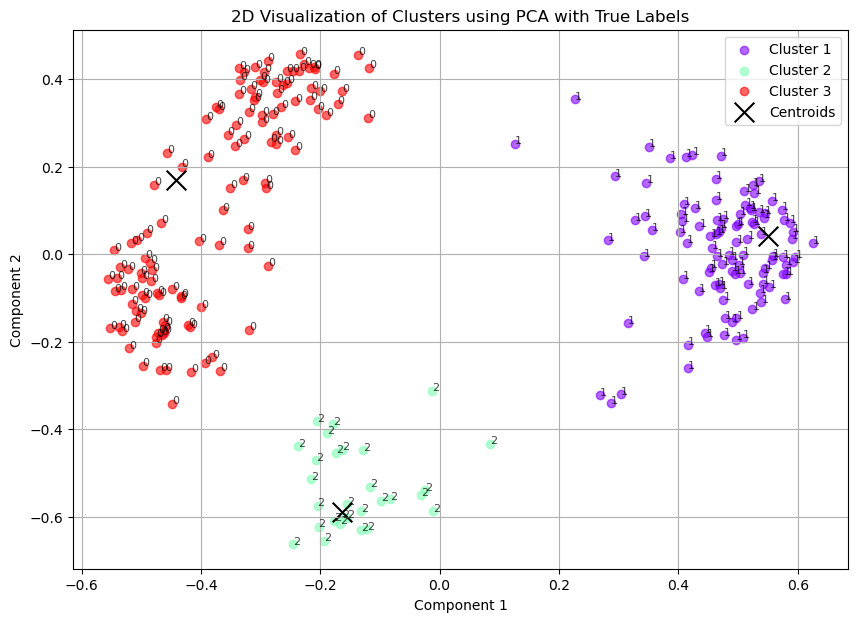

In [32]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np_norm, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)


Explained Variance Ratio (Component 1): 0.3385


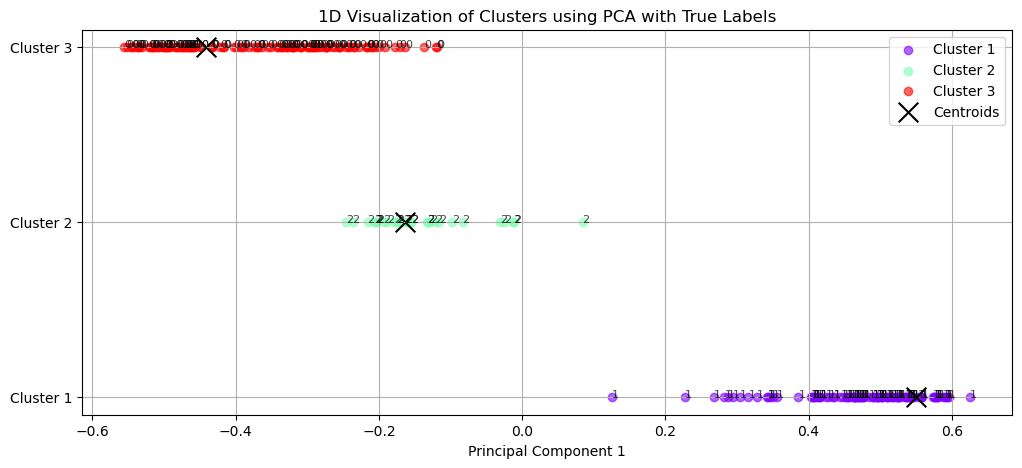

In [41]:
# Apply PCA after K-Means clustering for 1D visualization
X_1D_pca, centroids_1D_pca = reduce_to_1D_pca(feats_np_norm, centroids)

# Plot the 1D clusters with centroids and true labels
plot_1D_clusters_with_labels(X_1D_pca, centroids_1D_pca, idx, labels_np, K)

Explained Variance Ratio (Component 1): 0.3385


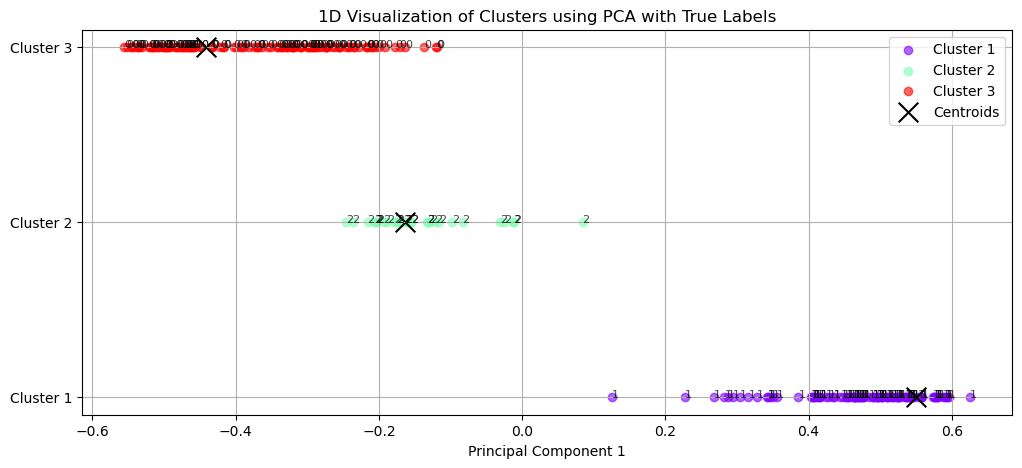

Explained Variance Ratio (Component 1): 0.3385
Explained Variance Ratio (Component 2): 0.1486


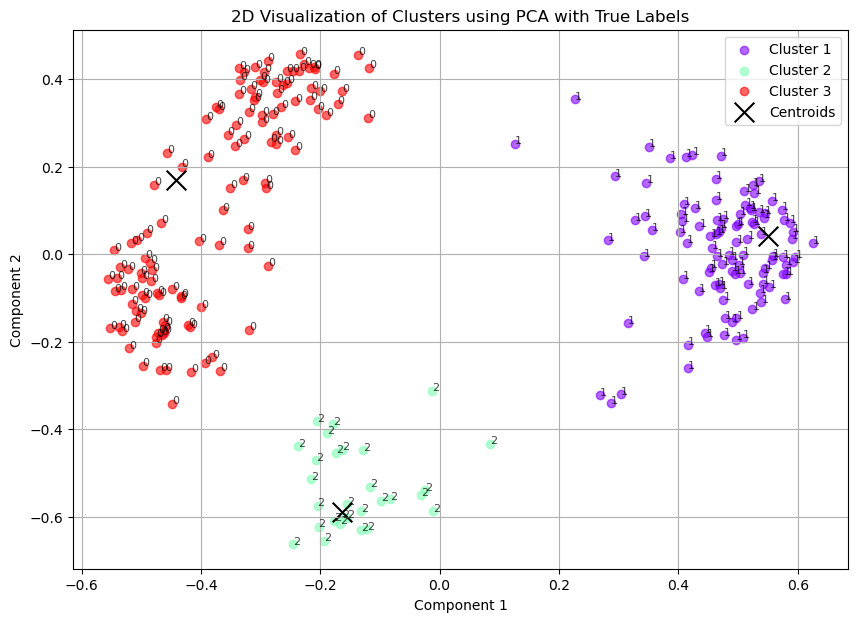

In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np  # Ensure np is imported for color mapping

# Function to reduce the dimensionality of data points and centroids to 1D using PCA
def reduce_to_1D_pca(X, centroids):
    # Initialize PCA with 1 component
    pca = PCA(n_components=1)

    # Apply PCA to the data points (X) and centroids
    X_1D = pca.fit_transform(X)  # Reducing original data points
    centroids_1D = pca.transform(centroids)  # Reducing centroids

    # Print the proportion of variance explained by PCA Component 1
    print(f"Explained Variance Ratio (Component 1): {pca.explained_variance_ratio_[0]:.4f}")

    return X_1D, centroids_1D

# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)

    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    # Print the proportion of variance explained by PCA Components 1 and 2
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio (Component 1): {explained_variance[0]:.4f}")
    print(f"Explained Variance Ratio (Component 2): {explained_variance[1]:.4f}")

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))

    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))

    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster

        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)

        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()

# Apply PCA after K-Means clustering for 1D visualization
X_1D_pca, centroids_1D_pca = reduce_to_1D_pca(feats_np_norm, centroids)

# Plot the 1D clusters with centroids and true labels
plot_1D_clusters_with_labels(X_1D_pca, centroids_1D_pca, idx, labels_np, K)

# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np_norm, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)


In [45]:
feats_np_norm.shape

(252, 512)

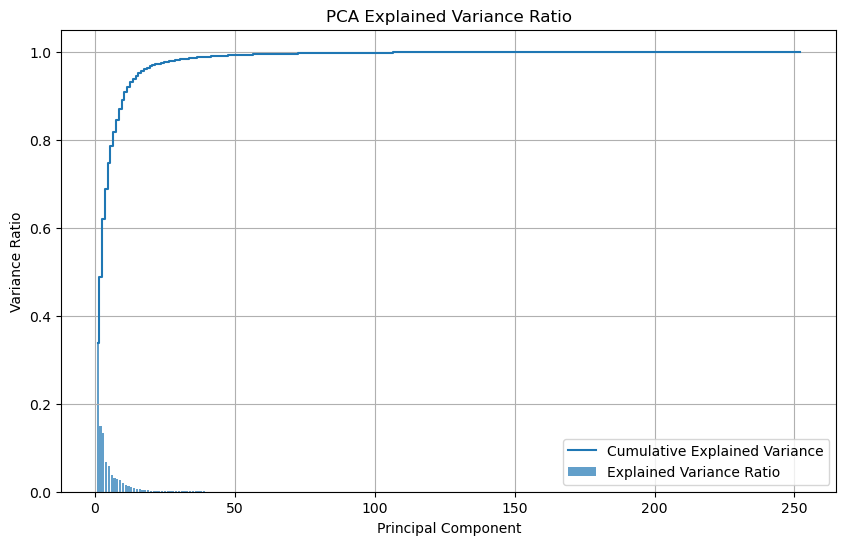

In [44]:
def plot_pca_variance_ratio(X):
    pca = PCA()
    pca.fit(X)
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Explained Variance Ratio')
    plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Explained Variance')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot explained variance ratio for all PCA components
plot_pca_variance_ratio(feats_np_norm)


In [54]:
# Function to calculate and print the number of components explaining a given variance
def compute_required_components(X, target_variance=0.9):
    pca = PCA()
    pca.fit(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= target_variance) + 1
    print(f"Number of components explaining {target_variance*100}% variance: {n_components}")
    return n_components

# Example usage:
n_components_90 = compute_required_components(feats_np_norm, target_variance=0.7)


Number of components explaining 70.0% variance: 5


Number of components explaining 90.00% variance: 11


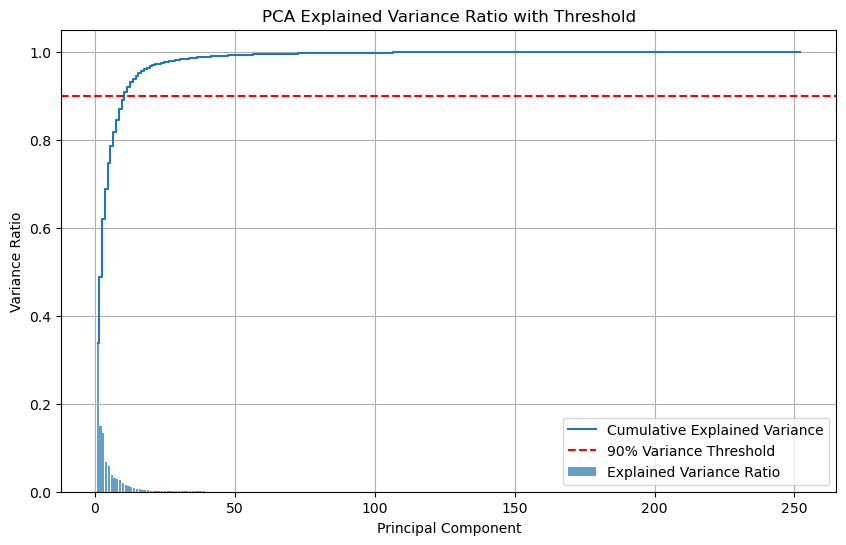

In [55]:
# Function to compute the number of components required to retain a target variance
def compute_required_components(X, target_variance=0.9):
    pca = PCA()
    pca.fit(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= target_variance) + 1
    print(f"Number of components explaining {target_variance * 100:.2f}% variance: {n_components}")
    return n_components

# Example usage for 90% variance
n_components_90 = compute_required_components(feats_np_norm, target_variance=0.9)

# Plot explained variance ratio again and annotate 90% variance line
def plot_pca_variance_ratio_with_threshold(X, target_variance=0.9):
    pca = PCA()
    pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot the explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Explained Variance Ratio')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
    plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{target_variance * 100:.0f}% Variance Threshold')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Ratio')
    plt.title('PCA Explained Variance Ratio with Threshold')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage for plotting with threshold
plot_pca_variance_ratio_with_threshold(feats_np_norm, target_variance=0.9)


In [56]:
# Function to order image vectors based on the first N PCA components
def order_images_by_pca(X, n_components=5):
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Project data onto the first n_components

    # Compute a weighted score for ordering
    explained_variance = pca.explained_variance_ratio_
    weights = explained_variance[:n_components]  # Get the weights for the components
    scores = np.dot(X_pca, weights)  # Weighted sum of PCA scores for each image

    # Order the indices of images based on the scores
    ordered_indices = np.argsort(scores)

    print(f"Explained Variance Ratios (First {n_components} Components): {explained_variance}")
    return ordered_indices, scores

# Example usage:
ordered_indices, scores = order_images_by_pca(feats_np_norm, n_components=5)

# Print the ordered indices
print("Ordered Indices of Images Based on Transition:", ordered_indices)


Explained Variance Ratios (First 5 Components): [0.3385454  0.14862557 0.13366492 0.06762349 0.05774082]
Ordered Indices of Images Based on Transition: [ 19 199  22 221  39 167 204 144 172 191 139   3  43  55 143  72   4  50
 151 159 104 163 235  12 130 232 137  44 157  49 113 243 106  16 223 100
  63 178 182 239  71  26   8 102 150  85  51  67  27  20 116  89 229 124
  86 141 234  10  52 241 105 202 208 198 192  73 246 131 207 132  33 189
 186 115 197 238 209 224   0  11   1  54 154 162 173 108 126 147  62  18
  65 184 123 101 217  13  47 218  90 175 136 170 242 190  96 226  79 201
  32 107 206 248 174 176  88 222 188 149 211 169  92  64  25 194 214 249
 129 236 245 220  66 120 142  87 203  24 112  46  69 200  82  35 111  80
  31  14   9  68 193 215  59  34 233 125  17 244 196 187  81   5 205 127
   6 110 164 185 240 230 177  60  78 237 216 119  48 128  30 213 179  61
   7  76 145 152  94 158 109  36 181 210  53  98  15  42 156  84  83 161
 171 114  95 135  37  93  41 212  56  91 250 

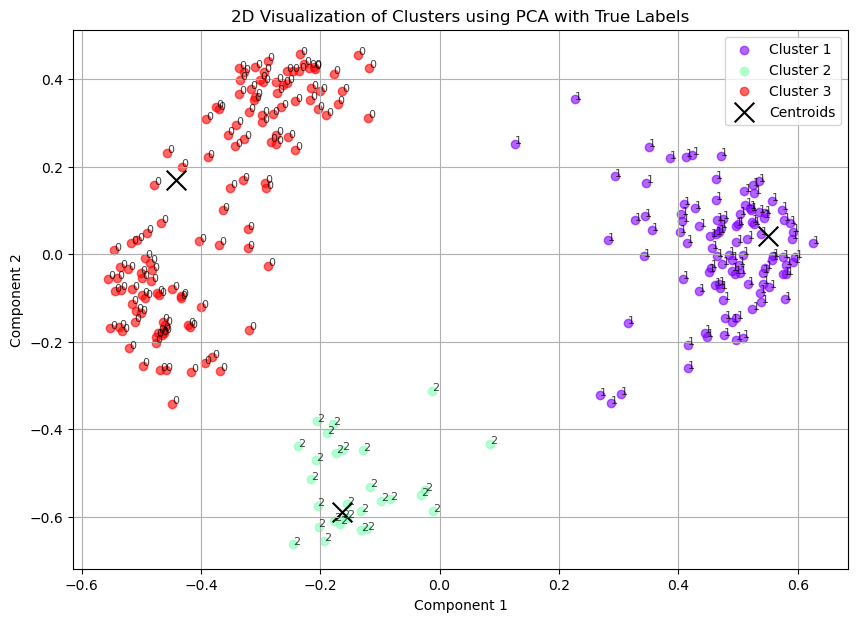

In [33]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np_norm, best_centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, best_idx, labels_np, K)


In [16]:
centroids

array([[2.21237950e-02, 8.05493749e-04, 3.26700340e-02, 2.01943781e-03,
        3.63597179e-02, 5.42119428e-04, 8.71797449e-02, 5.42080651e-02,
        3.62068428e-02, 4.29970796e-02, 4.04962112e-02, 1.03969536e-02,
        7.65247303e-02, 4.34883483e-02, 1.97588651e-02, 8.17779079e-03,
        1.09183729e-02, 8.06763469e-03, 1.01458529e-02, 1.54800402e-02,
        7.13928521e-02, 2.76184703e-03, 8.06668088e-02, 7.52792925e-02,
        1.29749889e-02, 7.58706155e-03, 4.27676622e-03, 4.12292661e-03,
        7.36970772e-03, 1.67265575e-02, 5.72882005e-02, 1.49400627e-02,
        8.08889783e-04, 3.43302702e-02, 7.30999531e-03, 1.11315907e-02,
        6.44013793e-02, 6.65111585e-03, 2.78813914e-03, 2.19458530e-06,
        8.58126752e-02, 8.57690313e-04, 6.86150833e-03, 7.09189170e-02,
        4.56465354e-02, 2.35440388e-03, 7.80487707e-02, 1.06620137e-03,
        1.91786559e-02, 5.53841369e-05, 1.31775739e-02, 5.45982763e-02,
        2.91883861e-02, 1.30200001e-02, 5.01097437e-02, 9.067473

In [47]:
zero = centroids[0]
zero

array([2.36899988e-02, 6.33561799e-02, 2.76721651e-02, 4.92519355e-02,
       6.32843885e-02, 5.87301790e-02, 4.30205473e-02, 1.48302636e-01,
       4.98830245e-02, 2.14780768e-02, 1.64720397e-02, 4.93823539e-02,
       5.26517378e-02, 5.90980461e-02, 1.82274487e-03, 1.01781184e-02,
       2.76064379e-02, 1.19882467e-01, 6.14478747e-02, 9.16417243e-02,
       6.06409586e-03, 8.82820501e-02, 5.88864978e-04, 5.40260337e-02,
       1.71544549e-02, 8.66179208e-05, 1.76684988e-03, 6.98565523e-02,
       1.46242247e-03, 9.14495179e-03, 5.26618486e-04, 3.31437344e-02,
       2.37050943e-02, 5.70583261e-03, 4.64117357e-04, 1.14004283e-01,
       2.72917310e-02, 1.43871117e-02, 4.22819342e-02, 6.10743733e-02,
       2.67775279e-03, 1.06353606e-03, 1.66219375e-03, 1.03155650e-01,
       1.85883092e-02, 4.37481650e-02, 2.44622448e-03, 1.95628177e-03,
       3.38028805e-02, 8.33990435e-02, 3.17941558e-02, 4.43133968e-02,
       4.11323987e-02, 2.34453403e-03, 8.54444375e-02, 9.04299643e-02,
      

In [48]:
np.save("zero.npy", zero)

In [49]:
one = centroids[1]
one

array([2.21263409e-02, 8.05491011e-04, 3.26689116e-02, 2.01947146e-03,
       3.63583063e-02, 5.42146426e-04, 8.71796827e-02, 5.42099790e-02,
       3.62041756e-02, 4.29970025e-02, 4.04942102e-02, 1.03968951e-02,
       7.65257765e-02, 4.34872096e-02, 1.97587844e-02, 8.17938297e-03,
       1.09197063e-02, 8.06758723e-03, 1.01459948e-02, 1.54793804e-02,
       7.13925020e-02, 2.76179481e-03, 8.06683734e-02, 7.52790256e-02,
       1.29757223e-02, 7.58756526e-03, 4.27703692e-03, 4.12286851e-03,
       7.37015654e-03, 1.67265249e-02, 5.72910115e-02, 1.49412104e-02,
       8.08831217e-04, 3.43267063e-02, 7.31082980e-03, 1.11315396e-02,
       6.43986709e-02, 6.65074705e-03, 2.78806393e-03, 2.19457803e-06,
       8.58139000e-02, 8.57601598e-04, 6.86160062e-03, 7.09173428e-02,
       4.56466021e-02, 2.35434837e-03, 7.80439846e-02, 1.06615960e-03,
       1.91781234e-02, 5.53859809e-05, 1.31773110e-02, 5.45989328e-02,
       2.91887189e-02, 1.30203920e-02, 5.01087619e-02, 9.06754926e-03,
      

In [50]:
np.save("one.npy", one)

In [51]:
two = centroids[2]
two

array([2.37947899e-02, 4.05615044e-02, 1.41009938e-02, 7.24769340e-02,
       2.07343370e-03, 6.03264199e-02, 6.22698761e-03, 4.23017184e-02,
       1.27944455e-04, 1.02261586e-02, 2.51693990e-03, 5.63334124e-02,
       2.08680754e-02, 1.24073726e-02, 6.69440164e-02, 3.93627820e-02,
       6.04341222e-02, 1.20006306e-01, 3.64135075e-02, 8.75781913e-05,
       2.72986344e-02, 1.14716105e-01, 1.13105303e-02, 3.82393553e-03,
       7.89290473e-02, 7.41697398e-02, 7.07437836e-02, 2.16166642e-02,
       2.59766420e-02, 1.86746634e-03, 1.08003428e-02, 4.05937861e-02,
       1.89739685e-02, 1.46307232e-02, 1.33041511e-02, 7.26596091e-03,
       1.54597459e-02, 1.04583753e-01, 5.27457914e-03, 1.94010576e-02,
       5.01758647e-03, 1.17186911e-01, 2.09687853e-03, 2.97991141e-02,
       7.62693493e-06, 2.65565208e-02, 2.57527123e-03, 1.66654747e-02,
       9.03015046e-02, 5.97623537e-04, 5.44493127e-02, 3.96469803e-02,
       3.83873843e-02, 3.55789004e-02, 3.13094308e-02, 6.49203839e-05,
      

In [52]:
np.save("two.npy", two)

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np  # Ensure np is imported for color mapping

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np  # Ensure np is imported for color mapping

# Function to reduce the dimensionality of data points and centroids to 1D using PCA
def reduce_to_1D_pca(X, centroids):
    # Initialize PCA with 1 component
    pca = PCA(n_components=1)

    # Apply PCA to the data points (X) and centroids
    X_1D = pca.fit_transform(X)  # Reducing original data points
    centroids_1D = pca.transform(centroids)  # Reducing centroids

    # Print the proportion of variance explained by PCA Component 1
    print(f"Explained Variance Ratio (Component 1): {pca.explained_variance_ratio_[0]:.4f}")

    return X_1D, centroids_1D

# Function to plot 1D visualization of clustered data points and centroids with true labels
def plot_1D_clusters_with_labels(X_1D, centroids_1D, idx, labels, K):
    plt.figure(figsize=(12, 5))

    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))

    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_1D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster

        # Scatter plot for each cluster along the 1D axis
        plt.scatter(cluster_points[:, 0], [k] * len(cluster_points),  
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)

        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], k), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_1D[:, 0], range(K), 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("1D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Principal Component 1")
    plt.yticks(range(K), [f"Cluster {k+1}" for k in range(K)])
    plt.legend()
    plt.grid()
    plt.show()


Explained Variance Ratios (First 1 Components): [0.33854532]


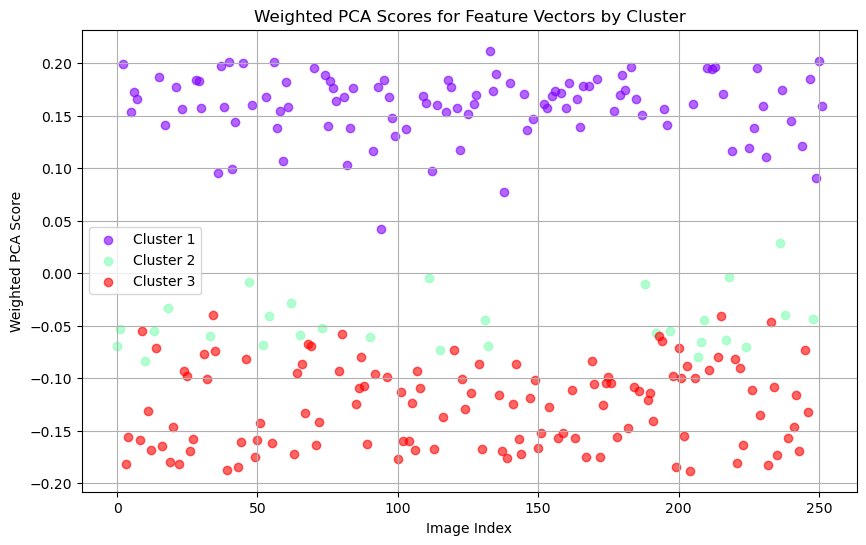

In [60]:
# Function to order image vectors based on the first N PCA components
def order_images_by_pca(X, n_components=1):
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Project data onto the first n_components

    # Compute a weighted score for ordering
    explained_variance = pca.explained_variance_ratio_
    weights = explained_variance[:n_components]  # Get the weights for the components
    scores = np.dot(X_pca, weights)  # Weighted sum of PCA scores for each image

    # Order the indices of images based on the scores
    ordered_indices = np.argsort(scores)

    print(f"Explained Variance Ratios (First {n_components} Components): {explained_variance}")
    return ordered_indices, scores

# Function to plot the weighted PCA scores for feature vectors with cluster colors
def plot_weighted_pca_scores_with_clusters(scores, idx, K):
    plt.figure(figsize=(10, 6))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    for k in range(K):
        cluster_scores = scores[idx == k]  # Filter scores by cluster
        plt.scatter(np.where(idx == k)[0], cluster_scores, 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
    
    plt.title("Weighted PCA Scores for Feature Vectors by Cluster")
    plt.xlabel("Image Index")
    plt.ylabel("Weighted PCA Score")
    plt.legend()
    plt.grid()
    plt.show()

# Order images based on the first 5 PCA components and plot their weighted PCA scores
ordered_indices, scores = order_images_by_pca(feats_np_norm, n_components=1)
plot_weighted_pca_scores_with_clusters(scores, idx, K)



In [93]:
# Function to order image vectors based on the first N PCA components
def order_images_by_pca(X, n_components=3):
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Project data onto the first n_components

    # Compute a weighted score for ordering
    explained_variance = pca.explained_variance_ratio_
    weights = explained_variance[:n_components]  # Get the weights for the components
    scores = np.dot(X_pca, weights)  # Weighted sum of PCA scores for each image

    # Order the indices of images based on the scores
    ordered_indices = np.argsort(scores)

    print(f"Explained Variance Ratios (First {n_components} Components): {explained_variance}")
    return ordered_indices, scores

In [100]:
ordered_indices, scores = order_images_by_pca(feats_np_norm, n_components=1)

Explained Variance Ratios (First 1 Components): [0.3385455]


In [101]:
# Function to plot weighted PCA scores with clusters styled like 1D cluster plots
def plot_weighted_pca_scores_like_1D(scores, idx, K):
    plt.figure(figsize=(12, 5))

    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))

    # Plot scores grouped by clusters
    for k in range(K):
        cluster_scores = scores[idx == k]  # Filter scores by cluster
        plt.scatter(cluster_scores, [k] * len(cluster_scores), 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)

    plt.title("Weighted PCA Scores Styled Like 1D Clusters")
    plt.xlabel("Weighted PCA Score")
    plt.yticks(range(K), [f"Cluster {k+1}" for k in range(K)])
    plt.legend()
    plt.grid()
    plt.show()


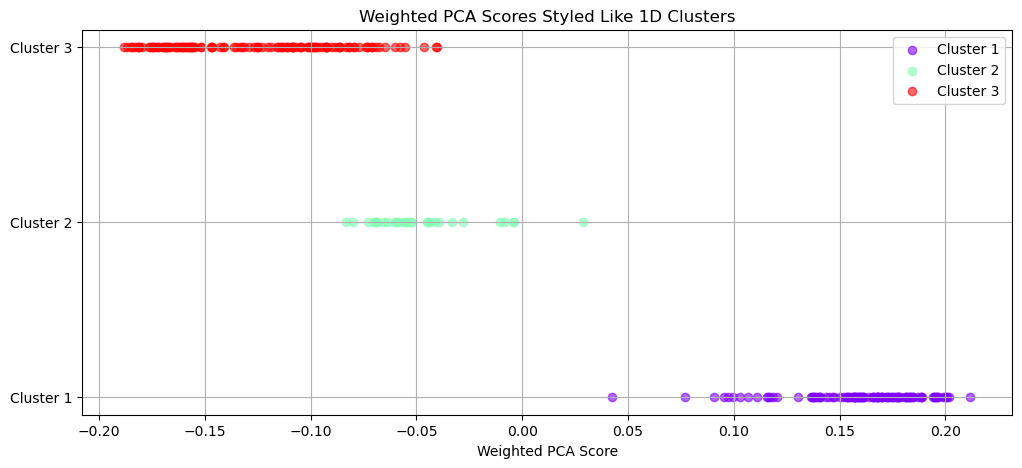

In [102]:
plot_weighted_pca_scores_like_1D(scores, idx, K)


Explained Variance Ratios (First 1 Components): [0.3385455]


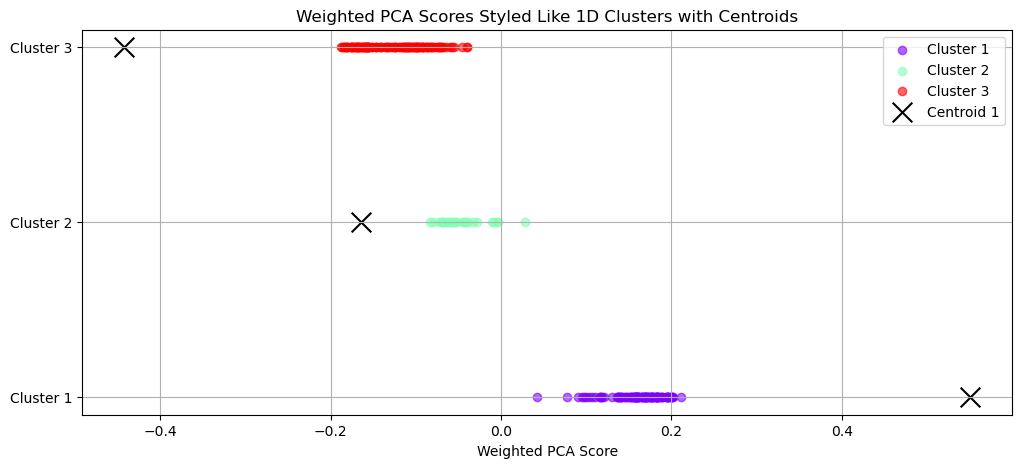

In [92]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np  # Ensure np is imported for color mapping

# Function to reduce the dimensionality of data points and centroids to 1D using PCA
def reduce_to_1D_pca(X, centroids):
    # Initialize PCA with 1 component
    pca = PCA(n_components=1)

    # Apply PCA to the data points (X) and centroids
    X_1D = pca.fit_transform(X)  # Reducing original data points
    centroids_1D = pca.transform(centroids)  # Reducing centroids

    # Print the proportion of variance explained by PCA Component 1
    print(f"Explained Variance Ratio (Component 1): {pca.explained_variance_ratio_[0]:.4f}")

    return X_1D, centroids_1D

# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)

    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    # Print the proportion of variance explained by PCA Components 1 and 2
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio (Component 1): {explained_variance[0]:.4f}")
    print(f"Explained Variance Ratio (Component 2): {explained_variance[1]:.4f}")

    return X_2D, centroids_2D

# Function to plot explained variance ratio for all PCA components
def plot_pca_variance_ratio(X):
    pca = PCA()
    pca.fit(X)
    explained_variance = pca.explained_variance_ratio_

    # Plot the explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Explained Variance Ratio')
    plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Explained Variance')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))

    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))

    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster

        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)

        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()

# Function to order image vectors based on the first N PCA components
def order_images_by_pca(X, centroids, n_components=3):
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Project data onto the first n_components
    centroids_pca = pca.transform(centroids)  # Transform centroids

    # Compute a weighted score for ordering
    explained_variance = pca.explained_variance_ratio_
    weights = explained_variance[:n_components]  # Get the weights for the components
    scores = np.dot(X_pca, weights)  # Weighted sum of PCA scores for each image

    # Order the indices of images based on the scores
    ordered_indices = np.argsort(scores)

    print(f"Explained Variance Ratios (First {n_components} Components): {explained_variance}")
    return ordered_indices, scores, centroids_pca

# Function to plot weighted PCA scores with clusters styled like 1D cluster plots, including centroids
def plot_weighted_pca_scores_like_1D(scores, centroids_pca, idx, K):
    plt.figure(figsize=(12, 5))

    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))

    # Plot scores grouped by clusters
    for k in range(K):
        cluster_scores = scores[idx == k]  # Filter scores by cluster
        plt.scatter(cluster_scores, [k] * len(cluster_scores), 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)

    # Plot centroids as larger markers
    for k in range(K):
        plt.scatter(centroids_pca[k, 0], k, 
                    c='k', marker='x', s=200, label=f'Centroid {k+1}' if k == 0 else None)

    plt.title("Weighted PCA Scores Styled Like 1D Clusters with Centroids")
    plt.xlabel("Weighted PCA Score")
    plt.yticks(range(K), [f"Cluster {k+1}" for k in range(K)])
    plt.legend()
    plt.grid()
    plt.show()

# Order images based on the first 4 PCA components and plot their weighted PCA scores with centroids
ordered_indices, scores, centroids_pca = order_images_by_pca(feats_np_norm, centroids, n_components=1)
plot_weighted_pca_scores_like_1D(scores, centroids_pca, idx, K)
